In [2]:
import jax
jax.config.update('jax_default_device',jax.devices()[-1])
import equinox as eqx
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from jax import grad, vmap
import optax
from diffrax import diffeqsolve, ODETerm, Dopri5, ControlTerm, Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree, Heun


#### Stochastic interpolants example (SDE)

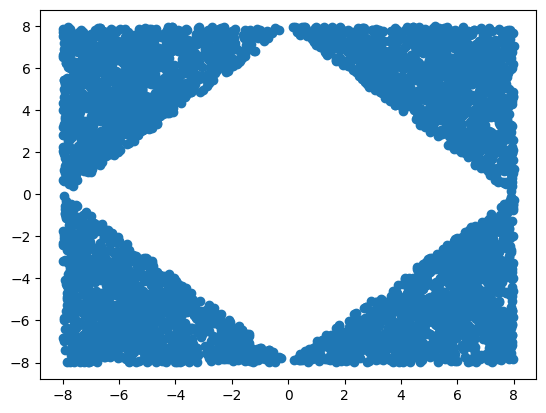

In [3]:
num_target = 5000
key = jax.random.PRNGKey(10)
target_samples = jax.random.uniform(key,shape = (10*num_target,2),minval=-1,maxval=1)
target_samples = 8 * target_samples[jnp.sum(jnp.abs(target_samples),1)>1.][:num_target]

num_reference = 10000
key = jax.random.PRNGKey(15)
reference_samples = jax.random.normal(key=key,shape=(num_reference,2))
plt.scatter(target_samples[:,0],target_samples[:,1])

In [53]:
class NeuralNetwork(eqx.Module):
    layers: list
    extra_bias: jax.Array

    def __init__(self, key):
        key1, key2, key3,key4 = jax.random.split(key, 4)
        # These contain trainable parameters.

        num_params_per_layer  = 256
        self.layers = [eqx.nn.Linear(3, num_params_per_layer, key=key1),
                       jax.nn.elu,
                       eqx.nn.Linear(num_params_per_layer, num_params_per_layer, key=key2),
                       jax.nn.elu,
                       eqx.nn.Linear(num_params_per_layer, num_params_per_layer, key=key3),
                       jax.nn.elu,
                       eqx.nn.Linear(num_params_per_layer, 2, key=key4)]
        # This is also a trainable parameter.
        self.extra_bias = jax.numpy.ones(2)

    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = jax.nn.relu(layer(x))
        return self.layers[-1](x) + self.extra_bias
    
def I(t,x,y):
    return jnp.cos(t)*x + jnp.sin(t)*y

def It(t,x,y):
    return -jnp.sin(t)*x + jnp.cos(t)*y

def gamma(t):
    return jnp.sqrt(2*t*(1-t))

gammadot = vmap(vmap(grad(gamma)))


@eqx.filter_jit  # compile this function to make it run fast.
# @eqx.filter_grad  # differentiate all floating-point arrays in `model`.
def loss(b_model, t, x, y, z):
    tx = jnp.hstack([t.reshape(-1,1),I(t,x,y)+gamma(t)*z])
    bhat = jax.vmap(b_model)(tx)  # vectorise the model over a batch of data


    bnorm2 = jnp.mean(jnp.sum(bhat**2,axis=1))
    dot_term = jnp.mean(jnp.sum((It(t,x,y) + gammadot(t)*z)*bhat,axis=1))
#     dot_term = 2 * jnp.mean(jnp.sum((It(t,x,y))*bhat,axis=1))
    return bnorm2 - 2*dot_term
    # return jnp.mean((bhat - (It(t,x,y) + gammadot(t)*z))**2)

def loss_denoise(eta_model,t,x,y,z):
    tx = jnp.hstack([t.reshape(-1,1),I(t,x,y)+gamma(t)*z])
    etahat = jax.vmap(eta_model)(tx)  # vectorise the model over a batch of data
    
    etanorm2 = jnp.mean(jnp.sum(etahat**2,axis=1))
    dot_term = jnp.mean(jnp.sum(etahat*z,axis=1))
    return etanorm2 - 2*dot_term

In [54]:
# t = jax.random.uniform(jax.random.PRNGKey(3),(num_target,1))
# z = jax.random.normal(jax.random.PRNGKey(4),(num_target,2))
# model = NeuralNetwork(jax.random.PRNGKey(0))
# loss(model,t,reference_samples,target_samples,z)
# loss_denoise(model,t,reference_samples,target_samples,z)

In [55]:
def evaluate_b(b_model, testloader):
    avg_loss = 0
    for t,x,y,z in testloader:
        avg_loss += loss(b_model,t,x,y,z)
    return avg_loss / 100

def evaluate_eta(eta_model, testloader):
    avg_loss = 0
    for t,x,y,z in testloader:
        avg_loss += loss_denoise(eta_model,t,x,y,z)
    return avg_loss / 100

In [56]:
def get_trainloader(batch_size = 512):
    batch_num = 0
    while True:
        batch_num+=1
        trainloader_key = jax.random.PRNGKey(batch_num)
        ref_key,target_key,normal_key,t_key = jax.random.split(trainloader_key,4)

        ref_batch = jax.random.choice(ref_key,reference_samples,(batch_size,))
        target_batch = jax.random.choice(target_key,target_samples,(batch_size,))

        t_vals = jax.random.uniform(t_key,(batch_size,1))

        z = jax.random.normal(normal_key,ref_batch.shape)

        yield t_vals,ref_batch,target_batch,z

def get_testloader(batch_size = 1000):
    num_batches = 100
    for i in range(num_batches):
        testloader_key = jax.random.PRNGKey(1000*i)
        ref_key,target_key,normal_key,t_key = jax.random.split(testloader_key,4)

        ref_batch = jax.random.choice(ref_key,reference_samples,(batch_size,))
        target_batch = jax.random.choice(target_key,target_samples,(batch_size,))

        t_vals = jax.random.uniform(t_key,(batch_size,1))

        z = jax.random.normal(normal_key,ref_batch.shape)
        yield t_vals,ref_batch,target_batch,z

In [57]:
def train_eta(
  model: NeuralNetwork,
  optim,
  steps,
  train_loader,
  print_every,
)  -> NeuralNetwork:
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    @eqx.filter_jit
    def make_step(
        model,
        opt_state,
        t,
        x,
        y,
        z
    ):
        loss_value, grads = eqx.filter_value_and_grad(loss_denoise)(model,t,x,y,z)
        updates, opt_state = optim.update(grads,opt_state,model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value
    train_losses = []
    
    for step, (t,x,y,z) in zip(range(steps), train_loader):
        model, opt_state, train_loss = make_step(model, opt_state, t,x,y,z)
        train_losses.append(train_loss)
        if jnp.isnan(train_loss):
            print("Nan")
            break
        if (step % print_every) == 0 or (step == steps - 1):
            testloader = get_testloader()
            test_loss = evaluate_eta(model, testloader)
            print("step=" + str(step) + " | train_loss=" + str(train_loss) + " | test_loss= "+ str(test_loss))

    return model,train_losses

def train_b(
  model: NeuralNetwork,
  optim,
  steps,
  train_loader,
  print_every,
)  -> NeuralNetwork:
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    #@eqx.filter_jit
    def make_step(
        model,
        opt_state,
        t,
        x,
        y,
        z
    ):
        loss_value, grads = eqx.filter_value_and_grad(loss)(model,t,x,y,z)
        if jnp.isnan(grads.layers[0].weight).any():
            print(grads.layers[0].weight[0][:10])
            tx = jnp.hstack([t.reshape(-1,1),I(t,x,y)+gamma(t)*z])

            print("Any nans predicted?")
            print(jnp.isnan(jax.vmap(model)(tx)).any())
            print("Loss value")
            inds = range(0,len(t))
            loss_sub_batches = jnp.array([
                loss(model,t[lower:lower+1],x[lower:lower+1],y[lower:lower+1],z[lower:lower+1]) for lower in inds
            ])
            bad_batches = jnp.isnan(loss_sub_batches)
            print('t',t[bad_batches])
            print('x',x[bad_batches])
            print('y',y[bad_batches])
            print('z',z[bad_batches])



        updates, opt_state = optim.update(grads,opt_state,model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value
    train_losses = []
    
    for step, (t,x,y,z) in zip(range(steps), train_loader):
        model, opt_state, train_loss = make_step(model, opt_state, t,x,y,z)
        train_losses.append(train_loss)
        if jnp.isnan(train_loss):
            print("GOT A NAN AT STEP",step)
            break
        if (step % print_every) == 0 or (step == steps - 1):
            testloader = get_testloader()
            test_loss = evaluate_b(model, testloader)
            print("step=" + str(step) + " | train_loss=" + str(train_loss) + " | test_loss= "+ str(test_loss))

    return model,train_losses

In [52]:
lr_shifts = {
      100:0.2,
      1000:0.5,
      5000:0.1,
      10000:0.5,
      15000:0.5,
      20000:0.5
   }


schedule = optax.piecewise_constant_schedule(
   1e-2,lr_shifts
)


b_optim = optax.chain(
   optax.clip_by_global_norm(1e-5),
   optax.adam(schedule),
)
b_model = NeuralNetwork(jax.random.PRNGKey(420))
b_trainloader = get_trainloader(batch_size = 5000)

b_model,b_losses = train_b(b_model,b_optim,steps=40000,train_loader=b_trainloader,print_every=50)

step=0 | train_loss=2.7841272 | test_loss= -13.617403


step=50 | train_loss=-30.601566 | test_loss= -30.24044
step=100 | train_loss=-31.271442 | test_loss= -31.436436
step=150 | train_loss=-31.688221 | test_loss= -31.598999
step=200 | train_loss=-31.200294 | test_loss= -31.563522
step=250 | train_loss=-31.248524 | test_loss= -31.641811
[nan nan nan]
Any nans predicted?
False
Loss value
t [[0.]]
x [[-2.2446394  -0.64164764]]
y [[-7.9821186 -1.7217865]]
z [[-1.2574993 -1.6917692]]
GOT A NAN AT STEP 287


In [44]:
b_losses

[Array(2.7841272, dtype=float32),
 Array(-13.822346, dtype=float32),
 Array(-15.426292, dtype=float32),
 Array(-7.5367737, dtype=float32),
 Array(-11.392895, dtype=float32),
 Array(-19.136929, dtype=float32),
 Array(-24.422968, dtype=float32),
 Array(-22.230913, dtype=float32),
 Array(-22.275444, dtype=float32),
 Array(-22.946507, dtype=float32),
 Array(-25.540854, dtype=float32),
 Array(-23.386898, dtype=float32),
 Array(-25.037235, dtype=float32),
 Array(-23.7486, dtype=float32),
 Array(-22.654116, dtype=float32),
 Array(-25.467012, dtype=float32),
 Array(-25.067362, dtype=float32),
 Array(-26.508394, dtype=float32),
 Array(-26.079567, dtype=float32),
 Array(-26.544024, dtype=float32),
 Array(-27.232862, dtype=float32),
 Array(-27.790674, dtype=float32),
 Array(-27.372688, dtype=float32),
 Array(-29.284372, dtype=float32),
 Array(-29.07373, dtype=float32),
 Array(-29.500328, dtype=float32),
 Array(-29.402151, dtype=float32),
 Array(-29.01279, dtype=float32),
 Array(-29.649727, dtype=

In [24]:
lr_shifts = {
      1000:0.5,
      5000:0.1,
      10000:0.5,
      15000:0.5,
      20000:0.5
   }


schedule = optax.piecewise_constant_schedule(
   1e-3,lr_shifts
)


eta_optim = optax.chain(
   optax.adam(schedule),
)

eta_trainloader = get_trainloader(batch_size = 128)

eta_model = NeuralNetwork(jax.random.PRNGKey(420))
eta_model,eta_losses = train_eta(eta_model,eta_optim,steps=40000,train_loader=eta_trainloader,print_every=5000)

step=0 | train_loss=2.1169572 | test_loss= 168.41092
step=5000 | train_loss=-0.2771662 | test_loss= -0.24497792
step=10000 | train_loss=-0.1894488 | test_loss= -0.25749892
step=15000 | train_loss=-0.2875368 | test_loss= -0.25891697
step=20000 | train_loss=-0.31756464 | test_loss= -0.26018253
step=25000 | train_loss=-0.22100097 | test_loss= -0.2607611
step=30000 | train_loss=-0.21786687 | test_loss= -0.260921
step=35000 | train_loss=-0.15470698 | test_loss= -0.26089966
step=39999 | train_loss=-0.37241423 | test_loss= -0.26106775


In [25]:
eps = 0.2
epsilon = lambda t: t*(1-t)*eps 

vmapped_b_model = vmap(b_model)
vmapped_eta_model = vmap(eta_model)
def dX_t(t,x,args):
    t_vec = jnp.ones((len(x),1))*t
    return vmapped_b_model(jnp.hstack([t_vec,x])) - (epsilon(t)/(gamma(t)+1e-12))*vmapped_eta_model(jnp.hstack([t_vec,x]))



t0, t1 = 0.0, 1.0
# t_vec = jnp.ones((len(x),1))*t
# drift = lambda t, x, args: dX_t(t,x)
diffusion = lambda t, x, args: 2*jnp.sqrt(2*epsilon(t))
brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-3, shape=(), key=jax.random.PRNGKey(1))
terms = MultiTerm(ODETerm(dX_t), ControlTerm(diffusion, brownian_motion))
solver = Heun()
saveat = SaveAt(dense=True)

sol = diffeqsolve(terms, solver, t0, t1, dt0=0.005, y0=reference_samples.copy(), saveat=saveat)
X = sol.evaluate(1.0)
print(X)  

[[-2.9172425  4.6288447]
 [ 6.370421  -3.7894776]
 [-4.539945  -4.9516544]
 ...
 [ 5.46829    2.995855 ]
 [ 3.628797   5.802954 ]
 [ 3.670683   5.3677754]]


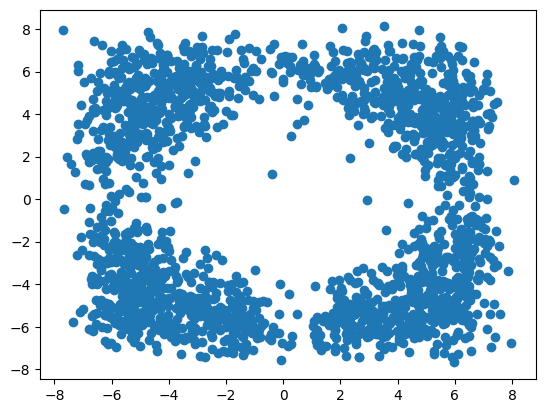

In [26]:
plt.scatter(X[:,0],X[:,1])

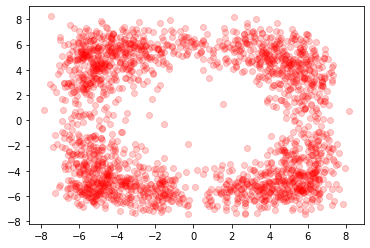

In [131]:
plt.scatter(X[:,0],X[:,1],c='red',alpha = 0.2)

# Make pretty flow plots later

In [120]:
X_hist = jnp.array(X_hist)
plt.scatter(X0[:,0],X0[:,1],c='red',alpha = 0.5)
plt.scatter(X[:,0],X[:,1],c='black',alpha = 0.5)

for i in range(500):
    plt.plot(X_hist[:,i,0],X_hist[:,i,1],c='blue',alpha = 0.05,lw = 5)

NameError: name 'X_hist' is not defined

In [ ]:
term = ODETerm(dX_t)
solver = Dopri5()
X0 = reference_samples
solution = diffeqsolve(term, solver, t0=0, t1=1., dt0=0.01, y0=X0)